In [18]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import os
import time
import random
import io
print(f"torch version : {torch.__version__}")

torch version : 2.0.0


In [19]:
model_paths = ["C:/junha/Personal_Notebook/models/efficientNet_OverSampling.pth",
               "C:/junha/Personal_Notebook/models/efficientNetV2_OverSampling.pth",
               "C:/junha/Personal_Notebook/models/swinTransformer_OverSampling.pth",
               "C:/junha/Personal_Notebook/models/swinTransformer_Tiny_OverSampling.pth",
               "C:/junha/Personal_Notebook/models/tinyVGG_OverSampling.pth",
               "C:/junha/Personal_Notebook/models/half_tinyVGG_OverSampling.pth",
               "C:/junha/Personal_Notebook/models/quarter_tinyVGG_OverSampling.pth"]

In [20]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, in_features: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

tiny_vgg_variants = {
    "tinyVGG_OverSampling": 1278900,
    "half_tinyVGG_OverSampling": 313000,
    "quarter_tinyVGG_OverSampling": 74400
}

# Instantiate TinyVGG models and load state dicts
tiny_vgg_models = {}
for model_name, in_features in tiny_vgg_variants.items():
    model = TinyVGG(input_shape=3, hidden_units=10, output_shape=2, in_features=in_features)
    model.load_state_dict(torch.load(f"C:/junha/Personal_Notebook/models/{model_name}.pth"))
    model.eval()
    tiny_vgg_models[model_name] = model


In [21]:
models = [
    torchvision.models.efficientnet_b0(),
    torchvision.models.efficientnet_v2_l(),
    torchvision.models.swin_v2_b(),
    torchvision.models.swin_v2_t(),
] + list(tiny_vgg_models.values())

model_names = ["EfficientNet B0", "EfficientNet V2 Large", "Swin Transformer Base", "Swin Transformer Tiny"] + list(tiny_vgg_variants.keys())

In [22]:
image_folder = "C:\junha\Personal_Notebook\oversampling_data\z_keep_out_for_final_test"
classes = ['defect', 'normal']

In [23]:
image_size = (2532, 824) 

In [28]:
transforms_dict = {
    "EfficientNet B0": transforms.Compose([transforms.Resize((2532, 824)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    "EfficientNet V2 Large": transforms.Compose([transforms.Resize((2532, 824)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    "Swin Transformer Base": transforms.Compose([transforms.Resize((2532, 824)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    "Swin Transformer Tiny": transforms.Compose([transforms.Resize((2532, 824)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
     "tinyVGG_OverSampling": transforms.Compose([transforms.Resize((2532, 824)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    "half_tinyVGG_OverSampling": transforms.Compose([transforms.Resize((1266, 412)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    "quarter_tinyVGG_OverSampling": transforms.Compose([transforms.Resize((633, 206)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
}

In [29]:
for i, model in enumerate(models):
    # Adjust classifier for 2 classes if necessary
    try:
        if 'efficientnet' in model.__class__.__name__.lower():
            model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
        elif 'swin' in model.__class__.__name__.lower():
            model.head = torch.nn.Linear(model.head.in_features, 2)
    except AttributeError:
        # No adjustment needed for TinyVGG models; skip and continue
        pass

    # Load state dictionary for each model
    state_dict = torch.load(model_paths[i])
    model.load_state_dict(state_dict)
    model.eval()
    print(f"Model #{i} ({model.__class__.__name__}) loaded successfully.")


Model #0 (EfficientNet) loaded successfully.
Model #1 (EfficientNet) loaded successfully.
Model #2 (SwinTransformer) loaded successfully.
Model #3 (SwinTransformer) loaded successfully.
Model #4 (TinyVGG) loaded successfully.
Model #5 (TinyVGG) loaded successfully.
Model #6 (TinyVGG) loaded successfully.


In [30]:
all_images = []
for label, class_name in enumerate(classes):
    class_folder = os.path.join(image_folder, class_name)
    for filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, filename)
        all_images.append((image_path, label))  

# Shuffle images for random processing
random.shuffle(all_images)

In [31]:
# Initialize lists to store accuracy and timing for each model
accuracies = []
average_times = []

# Evaluate each model with tqdm
for model, model_name in zip(models, model_names):
    correct_predictions = 0
    total_images = 0
    processing_times = []
    transform = transforms_dict[model_name]  # Ensure correct transform for each model

    # Progress bar for each model's evaluation
    with torch.no_grad():
        for image_path, label in tqdm(all_images, desc=f"Evaluating {model_name} on shuffled images"):
            # Load and preprocess the image
            image = Image.open(image_path).convert("RGB")
            image = transform(image).unsqueeze(0)

            # Measure inference time
            start_time = time.time()
            output = model(image)
            end_time = time.time()

            # Record time and calculate prediction
            processing_times.append(end_time - start_time)
            _, predicted = torch.max(output, 1)

            # Retrieve labels for display purposes (optional)
            actual_label = classes[label]
            predicted_label = classes[predicted.item()]

            # Update accuracy counters
            correct_predictions += (predicted.item() == label)
            total_images += 1

    # Calculate accuracy and average processing time for the model
    accuracy = correct_predictions / total_images
    avg_time = sum(processing_times) / len(processing_times)

    # Store results
    accuracies.append(accuracy)
    average_times.append(avg_time)

    # Print model-specific results
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Average Processing Time per Image: {avg_time:.4f} seconds\n")

# Final summary of accuracies and average times for all models
print("Summary of Model Performance:")
for model_name, accuracy, avg_time in zip(model_names, accuracies, average_times):
    print(f"Model: {model_name} | Accuracy: {accuracy:.4f} | Average Time: {avg_time:.4f} seconds")


Evaluating EfficientNet B0 on shuffled images: 100%|██████████| 40/40 [00:43<00:00,  1.08s/it]



Model: EfficientNet B0
Accuracy: 0.9500
Average Processing Time per Image: 1.0429 seconds


Evaluating EfficientNet V2 Large on shuffled images: 100%|██████████| 40/40 [03:55<00:00,  5.89s/it]



Model: EfficientNet V2 Large
Accuracy: 0.9500
Average Processing Time per Image: 5.8472 seconds


Evaluating Swin Transformer Base on shuffled images: 100%|██████████| 40/40 [04:03<00:00,  6.08s/it]



Model: Swin Transformer Base
Accuracy: 1.0000
Average Processing Time per Image: 6.0465 seconds


Evaluating Swin Transformer Tiny on shuffled images: 100%|██████████| 40/40 [01:40<00:00,  2.51s/it]



Model: Swin Transformer Tiny
Accuracy: 1.0000
Average Processing Time per Image: 2.4706 seconds


Evaluating tinyVGG_OverSampling on shuffled images: 100%|██████████| 40/40 [00:09<00:00,  4.21it/s]



Model: tinyVGG_OverSampling
Accuracy: 1.0000
Average Processing Time per Image: 0.2000 seconds


Evaluating half_tinyVGG_OverSampling on shuffled images: 100%|██████████| 40/40 [00:02<00:00, 13.58it/s]



Model: half_tinyVGG_OverSampling
Accuracy: 1.0000
Average Processing Time per Image: 0.0475 seconds


Evaluating quarter_tinyVGG_OverSampling on shuffled images: 100%|██████████| 40/40 [00:01<00:00, 31.27it/s]


Model: quarter_tinyVGG_OverSampling
Accuracy: 1.0000
Average Processing Time per Image: 0.0117 seconds

Summary of Model Performance:
Model: EfficientNet B0 | Accuracy: 0.9500 | Average Time: 1.0429 seconds
Model: EfficientNet V2 Large | Accuracy: 0.9500 | Average Time: 5.8472 seconds
Model: Swin Transformer Base | Accuracy: 1.0000 | Average Time: 6.0465 seconds
Model: Swin Transformer Tiny | Accuracy: 1.0000 | Average Time: 2.4706 seconds
Model: tinyVGG_OverSampling | Accuracy: 1.0000 | Average Time: 0.2000 seconds
Model: half_tinyVGG_OverSampling | Accuracy: 1.0000 | Average Time: 0.0475 seconds
Model: quarter_tinyVGG_OverSampling | Accuracy: 1.0000 | Average Time: 0.0117 seconds


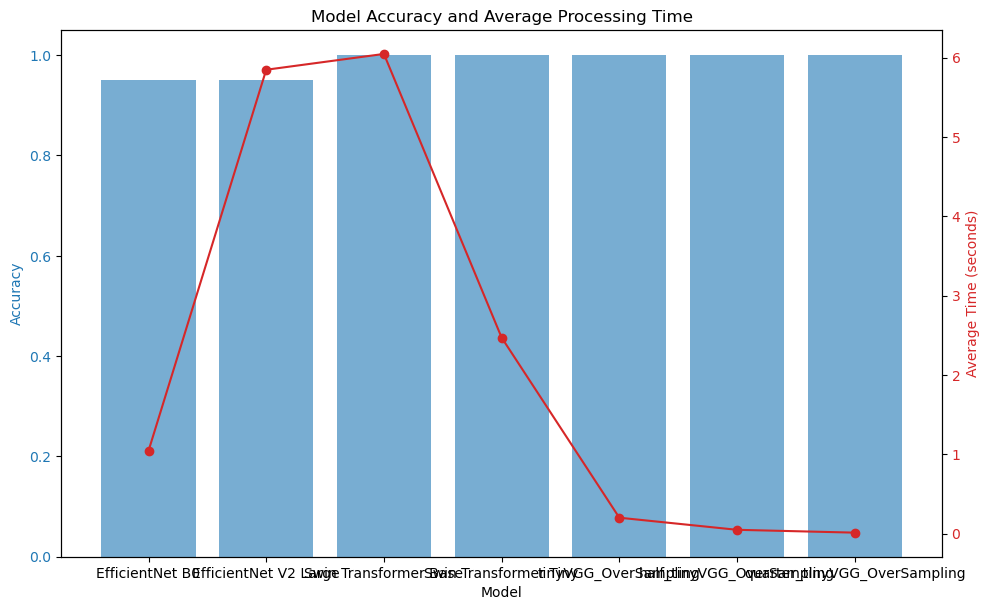

In [34]:
# Plot accuracy and processing time for each model
model_names = ["EfficientNet B0", "EfficientNet V2 Large", "Swin Transformer Base", "Swin Transformer Tiny", "tinyVGG_OverSampling", "half_tinyVGG_OverSampling", "quarter_tinyVGG_OverSampling"]
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
ax1.set_xlabel("Model")
ax1.set_ylabel("Accuracy", color="tab:blue")
ax1.bar(model_names, accuracies, color="tab:blue", alpha=0.6, label="Accuracy")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create a second y-axis for processing time
ax2 = ax1.twinx()
ax2.set_ylabel("Average Time (seconds)", color="tab:red")
ax2.plot(model_names, average_times, color="tab:red", marker="o", label="Processing Time")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Add legends
fig.tight_layout()
plt.title("Model Accuracy and Average Processing Time")
plt.show()